## Table of Content

1. [Import Libraries and create MYSQL connection](#section101)<br>
2. [Data Extraction and Exploration](#section2)<br>
    - 2.1 [Missing Data Imputation](#section201)<br>
         - 2.1.1 [Missing State](#section202)<br>
         - 2.1.2 [Missing Longitude and Latitude](#section203)<br>
         - 2.1.3 [Missing Device_ID](#section204)<br>
    - 2.2 [Anamoly Detection](#section205)<br>
    - 2.3 [Merging Datasets - Phone, Gender and Events](#section206)<br>
3. [Anamoly Detection](#section3)<br>
4. [Plotting of Distributions](#section4)<br>
    - 4.1 [Distribution of Users(device_id) across States](#section400)<br>
    - 4.2 [Distribution of Users across Phone Brands(10 Most used Phone Brands)](#section401)<br>
    - 4.3 [Distribution of Users across Gender](#section402)<br>
    - 4.4 [Distribution of Users across Age Segments](#section403)<br>
    - 4.5 [Distribution of Phone Brands(10 Most used Phone Brand): Age Segment, State, Gender](#section404)<br>
    - 4.6 [Distribution of Gender for each State, Age Segment and Phone Brand(10 Most used Phone Brands)](#section405)<br>
    - 4.7 [Distribution of Age Segments for each State, Gender and Phone Brand(10 Most used Phone Brands)](#section406)<br>
    - 4.8 [Hourly distribution of Phone Calls](#section407)<br>
    - 4.9 [Users on the Map using any suitable package](#section408)<br>
5. [Conclusion](#section5)
6. [CoreTeam](#sectioc6)

<a id=section101></a>
### 1. Import Libraries and Create MySQL Connection

In [ ]:
#!pip install mysql-connector

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from collections import Counter

import pandas_profiling
import matplotlib.pyplot as plt  
import seaborn as sns            
%matplotlib inline
sns.set()

#### Connection with the Database

In [2]:
# connection details
myDB = mysql.connector.connect(
   host="cpanel.insaid.co",
   user="student",
   passwd="student",
   database='Capstone1'
)

<a id=section2></a>
### 2. Data Extraction and Exploration

In [3]:
# open cursor
cursor = myDB.cursor()
# query
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE table_schema ='Capstone1'"
# execute query
cursor.execute(query)
# fetch results
result = cursor.fetchall()
# print results
for table in result:
    print (table)

# close connection
#cnx.close()

('events_data',)
('gender_age_train',)
('phone_brand_device_model',)


In [4]:
cursor = myDB.cursor()

#### Queries

In [5]:
query_gender_age_train = ("SELECT * FROM gender_age_train")
query_phone_brand_device_model = ("SELECT * FROM phone_brand_device_model")
#query_events_data = ("select * from events_data where state in ('TamilNadu', 'Manipur', 'Chandigarh', 'Tripura', 'UttarPradesh', 'ArunachalPradesh')")

In [6]:
cursor.execute(query_gender_age_train)
table_rows = cursor.fetchall()
df_gender_age_train = pd.DataFrame(table_rows,columns = ['device_id','gender','age','group'])

In [7]:
cursor.execute(query_phone_brand_device_model)
table_rows = cursor.fetchall()
df_phone_brand_device_model = pd.DataFrame(table_rows, columns=['device_id', 'phone_brand', 'device_model'])

In [ ]:
'''
def Read_GDrive_csv():
  #install PyDrive - Commnet If already Installed
  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  link = 'https://drive.google.com/open?id=1WMRSPomIeyrVkaEhxYaoeTgcLezVZCjC'
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('events_data.csv')
'''

In [ ]:
'''
import sys
IN_COLAB = 'google.colab' in sys.modules
if(IN_COLAB):
  Read_GDrive_csv()

df_all_events_data = pd.read_csv('events_data.csv')
'''

In [8]:
df_all_events_data = pd.read_csv("C://Users//vbhak//OneDrive//events_data.csv")

In [9]:
df_gender_age_train = pd.read_sql("SELECT * FROM gender_age_train", myDB)
df_phone_brand_device_model = pd.read_sql("SELECT * FROM phone_brand_device_model", myDB)
myDB.close()



In [10]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [11]:
missing_data(df_gender_age_train)

,Total,Percent
device_id,0,0.0
gender,0,0.0
age,0,0.0
group,0,0.0


In [12]:
missing_data(df_phone_brand_device_model)

,Total,Percent
device_id,0,0.0
phone_brand,0,0.0
device_model,0,0.0


In [13]:
missing_data(df_all_events_data)

,Total,Percent
device_id,453,0.013926
longitude,423,0.013004
latitude,423,0.013004
state,377,0.011589
event_id,0,0.000000
timestamp,0,0.000000
city,0,0.000000


####  Data Analysis - Gender Age data

In [14]:
df_gender_age_train.shape

(74645, 4)

In [15]:
df_gender_age_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device_id  74645 non-null  int64 
 1   gender     74645 non-null  object
 2   age        74645 non-null  int64 
 3   group      74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [16]:
df_gender_age_train.describe()

,device_id,age
count,7.464500e+04,74645.000000
mean,-7.491354e+14,31.410342
std,5.327150e+18,9.868735
min,-9.223067e+18,1.000000
25%,-4.617367e+18,25.000000
50%,-1.841362e+16,29.000000
75%,4.636656e+18,36.000000
max,9.222849e+18,96.000000


In [17]:
df_phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87726 entries, 0 to 87725
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     87726 non-null  int64 
 1   phone_brand   87726 non-null  object
 2   device_model  87726 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [18]:
df_gender_age_train.describe(include='all')

,device_id,gender,age,group
count,7.464500e+04,74645,74645.000000,74645
unique,NaN,2,NaN,12
top,NaN,M,NaN,M23-26
freq,NaN,47904,NaN,9605
mean,-7.491354e+14,NaN,31.410342,NaN
std,5.327150e+18,NaN,9.868735,NaN
min,-9.223067e+18,NaN,1.000000,NaN
25%,-4.617367e+18,NaN,25.000000,NaN
50%,-1.841362e+16,NaN,29.000000,NaN
75%,4.636656e+18,NaN,36.000000,NaN


**Observations** No Null Values in Gender Age Data

In [19]:
df_gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [20]:
df_gender_age_train['gender'].value_counts()

M    47904
F    26741
Name: gender, dtype: int64

Text(0, 0.5, 'Age Groups')

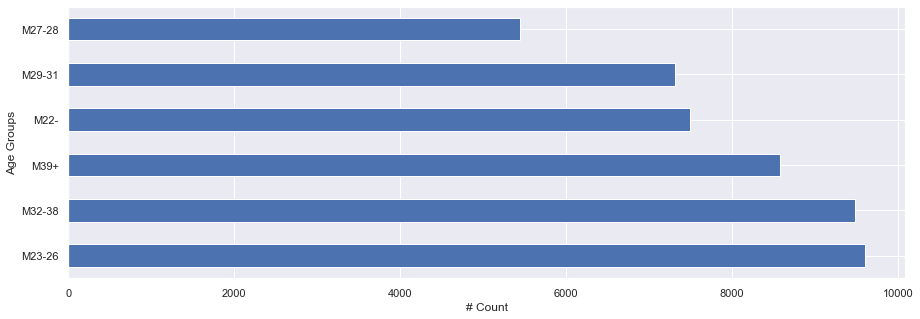

In [21]:
# Male users age group wise to see which group has maximum mobile usage
plt.figure(figsize=(15,5))
df_gender_age_train[df_gender_age_train['gender']=='M']['group'].value_counts().plot.barh()
plt.xlabel("# Count")
plt.ylabel("Age Groups")

Text(0, 0.5, 'Age Groups')

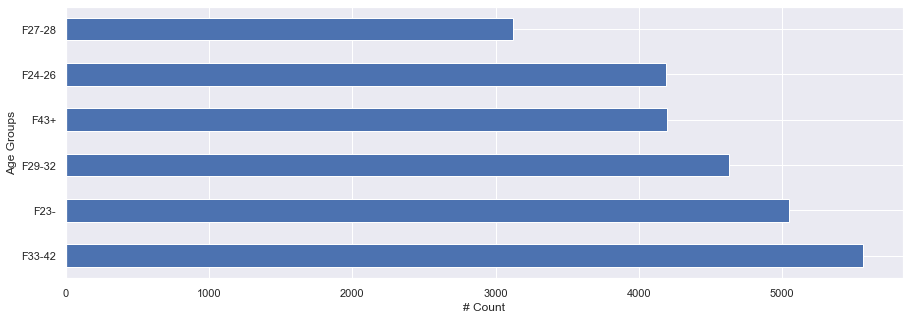

In [22]:
# Female users age group wise to see which group has maximum mobile usage
plt.figure(figsize=(15,5))
df_gender_age_train[df_gender_age_train['gender']=='F']['group'].value_counts().plot.barh()
plt.xlabel("# Count")
plt.ylabel("Age Groups")

Text(0.5, 0, 'Age')

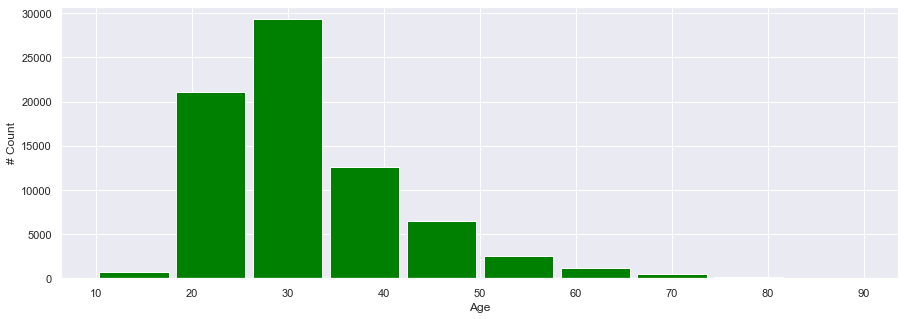

In [23]:
plt.figure(figsize=(15,5))
range = (10,90)
plt.hist(df_gender_age_train['age'], 10, range, color = 'green', histtype = 'bar', rwidth = 0.9)
plt.ylabel("# Count")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

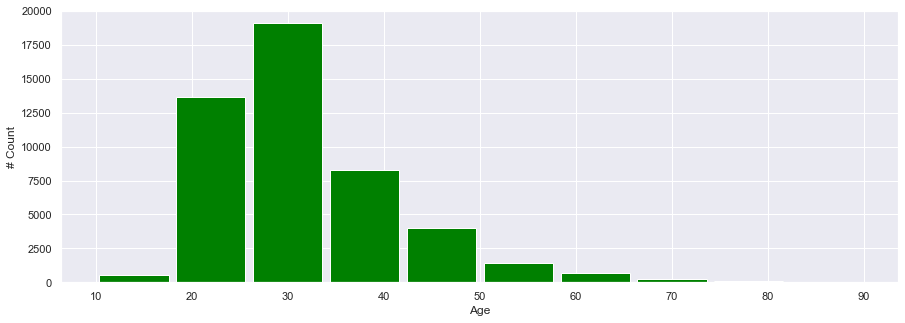

In [24]:
plt.figure(figsize=(15,5))
range = (10,90)
plt.hist(df_gender_age_train[df_gender_age_train['gender']=='M']['age'], 10, range, color = 'green', histtype = 'bar', rwidth = 0.9)
plt.ylabel("# Count")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

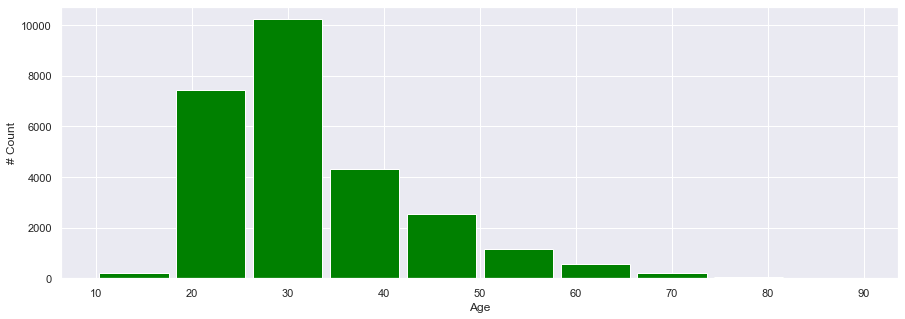

In [25]:
plt.figure(figsize=(15,5))
range = (10,90)
plt.hist(df_gender_age_train[df_gender_age_train['gender']=='F']['age'], 10, range, color = 'green', histtype = 'bar', rwidth = 0.9)
plt.ylabel("# Count")
plt.xlabel("Age")

In [26]:
# profile = pandas_profiling.ProfileReport(df_phone_brand_device_model)
# profile.to_file(output_file="phone_brand_device_model_data_before_preprocessing.html")

In [27]:
# profile = pandas_profiling.ProfileReport(df_gender_age_train)
# profile.to_file(output_file="gender_age_train_data_before_preprocessing.html")

**Observations** 
1. People of age group 20 to 40 are using mobiles more as compared to other age groups.
2. Mojority of people stops using mobile after the age of 60.
3. Males are using mobile more than females.
4. People start using mobile after the age of 10.  

Person whose age is 1 is also using mobile so it is outlier

#### Data Analysis - Phone Brand Data

In [28]:
df_phone_brand_device_model.shape

(87726, 3)

In [29]:
df_phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87726 entries, 0 to 87725
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     87726 non-null  int64 
 1   phone_brand   87726 non-null  object
 2   device_model  87726 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [30]:
df_phone_brand_device_model.describe()

,device_id
count,8.772600e+04
mean,-5.212557e+15
std,5.330157e+18
min,-9.223322e+18
25%,-4.623331e+18
50%,-3.109802e+16
75%,4.635194e+18
max,9.222849e+18


In [31]:
df_phone_brand_device_model.describe(include='all')

,device_id,phone_brand,device_model
count,8.772600e+04,87726,87726
unique,NaN,116,1467
top,NaN,小米,红米note
freq,NaN,21645,3500
mean,-5.212557e+15,NaN,NaN
std,5.330157e+18,NaN,NaN
min,-9.223322e+18,NaN,NaN
25%,-4.623331e+18,NaN,NaN
50%,-3.109802e+16,NaN,NaN
75%,4.635194e+18,NaN,NaN


**Observations** No Null Values in Phone Brand Device Data

In [32]:
df_phone_brand_device_model.head()

,device_id,phone_brand,device_model
0,1877775838486905855,vivo,Y13
1,-3766087376657242966,小米,V183
2,-6238937574958215831,OPPO,R7s
3,8973197758510677470,三星,A368t
4,-2015528097870762664,小米,红米Note2


**Observations** There are Chineese names for phone_brand & device_model which needs treatment

In [33]:
brands_in_chinese = ['华为','小米','三星','魅族','酷派','乐视','联想 ','vivo','OPPO','HTC','LG','TCL','LOGO','Lovme','ZUK','PPTV','努比亚','海信','天语','夏新','欧比', '优米', '欧博信', '奇酷', '锤子', '酷比魔方', '语信', '朵唯', '德赛', '一加',
       '华硕', '普耐尔', '易派', '摩托罗拉', '优购', '酷珀', '梦米', '爱派尔', '昂达', '邦华',
       '聆韵', '中国移动', '诺亚信', '酷比', '艾优尼', '斐讯', '富可视', '欧新', '美图', '宝捷讯',
       '青橙', '果米', '波导', '诺基亚', '神舟', '糯米', '亿通', '纽曼', '唯米', '百立丰',
       '沃普丰', '虾米', '凯利通', '贝尔丰', '至尊宝', '蓝魔', '青葱', '白米', '大可乐', '尼比鲁',
       '康佳', '乡米', '黑米', '海尔', '优语', '维图', '米歌', '广信', 'E派', '小杨树', '糖葫芦',
       '西米', '谷歌', '长虹', '飞利浦', '惠普', '台电', '大Q', '鲜米', '先锋', '欧奇']
brands_in_english = ['Huawei','Xiaomi','Samsung','Meizu','Coolpad','LeEco','Lenovo','vivo','OPPO','HTC','LG','TCL','LOGO','Lovme','ZUK','PPTV','Nubia','Hisense','Amagatarai','Amoi','Obi', 'Youmi', 'Obson', 'Qiku', 'Hammer', 'Cubei Cube', 'Letters', 'Duowei', 'Desai', 'One Plus','ASUS', 'Punale', 'Yipai', 'Motorola', 'Yougo', 'Cooper', 'Mengmi', 'Aipair', 'Onda', 'Banghua', 'Lingyun', 'China Mobile', 'Noah',' Coolby ',' Aiyouni ',' Feixun ',' Focus', 'Ou Xin', 'Meitu', 'Projet News','Green Orange', 'Fruit Rice', 'Flyer', 'Nokia', 'Shenzhou', 'Glutinous Rice', 'Yi Tong', 'Newman', 'Wei Mi', 'Bai Li Feng','Wopfung', 'Shrimp', 'Kellystone', 'Bellfonte', 'Extreme Treasure', 'Blue Devils', 'Scallion', 'White Rice', 'Big Cola', 'Nibiru','Kangjia', 'Xianmi', 'Black Rice', 'Haier', 'Youyu', 'Weitu', 'Mi Ge', 'Guangxin', 'E-Pay', 'Little Poplar', ' Candied ','Simi', 'Google', 'Changhong', 'Philips', 'HP', 'Taipower', 'Big Q', 'Fresh Rice', 'Pioneer', 'Ouqi']

brands_dict1 = dict(zip(brands_in_chinese, brands_in_english)) 


In [34]:
def translator(val):
    if val in brands_dict1:
        return brands_dict1[val]
    else:
        return val

In [35]:
df_phone_brand_device_model.phone_brand = df_phone_brand_device_model.phone_brand.apply(translator)

In [36]:
df_phone_brand_device_model.head()

,device_id,phone_brand,device_model
0,1877775838486905855,vivo,Y13
1,-3766087376657242966,Xiaomi,V183
2,-6238937574958215831,OPPO,R7s
3,8973197758510677470,Samsung,A368t
4,-2015528097870762664,Xiaomi,红米Note2


In [37]:
df_phone_brand_device_model['phone_brand'].value_counts().head(10)

Xiaomi     21645
Samsung    19211
Huawei     15181
vivo        7596
OPPO        6717
Meizu       5531
Coolpad     3979
HTC         1272
Lenovo       982
LeEco        841
Name: phone_brand, dtype: int64

Text(0.5, 0, 'Phone Brands')

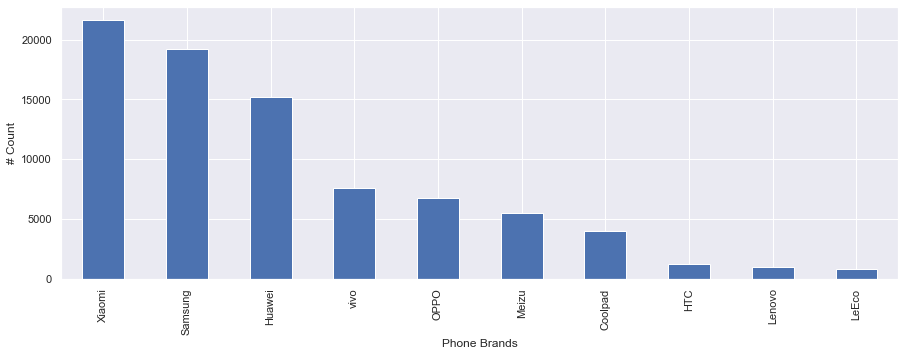

In [38]:
plt.figure(figsize=(15,5))
df_phone_brand_device_model['phone_brand'].value_counts().head(10).plot.bar()
plt.ylabel("# Count")
plt.xlabel("Phone Brands")

In [39]:
df_phone_brand_device_model['device_model'].value_counts().head(10)

红米note           3500
MI 3             2739
MI 2S            2547
Galaxy Note 3    2378
MI 4             2256
Galaxy S4        1910
Galaxy Note 2    1877
荣耀6              1471
荣耀畅玩4X           1279
荣耀3C             1206
Name: device_model, dtype: int64

In [40]:
df_phone_brand_device_model['device_model'].replace({'红米note': 'Redmi note', '荣耀6 plus': 'Redmi 1S', '天鉴W900S': 'Tianjian W900S','乐檬X3': 'Music lemon X3', '荣耀6': 'Glory 6', '荣耀畅玩4X': 'Honor Play 4X', '荣耀3C': 'Glory 3C', '荣耀6 Plus':'Honor 6 Plus' }, inplace=True)

Text(0.5, 0, 'Device Models')

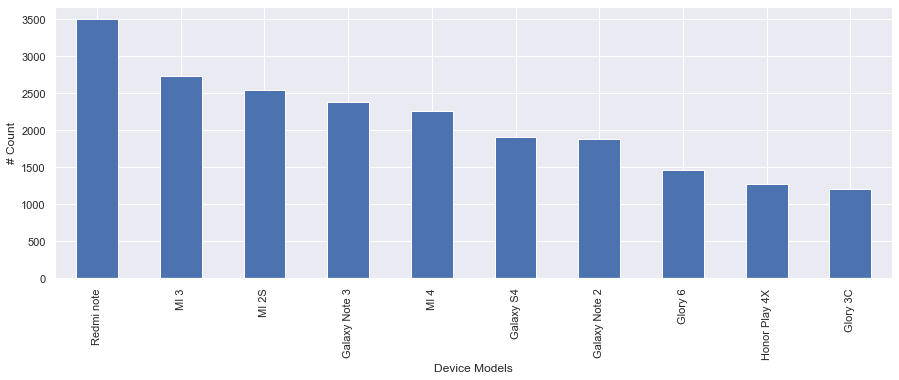

In [41]:
plt.figure(figsize=(15,5))
df_phone_brand_device_model['device_model'].value_counts().head(10).plot.bar()
plt.ylabel("# Count")
plt.xlabel("Device Models")

In [42]:
for i in df_phone_brand_device_model['phone_brand'].head(10).unique():
    print ('-----',i,'------')
    print (df_phone_brand_device_model[df_phone_brand_device_model['phone_brand']==i]['device_model'].value_counts().head())

----- vivo ------
X3T      425
X5Pro    401
X3L      333
Xplay    293
X5SL     279
Name: device_model, dtype: int64
----- Xiaomi ------
Redmi note    3500
MI 3          2739
MI 2S         2547
MI 4          2256
红米1S          1191
Name: device_model, dtype: int64
----- OPPO ------
R7         663
R7 Plus    459
R7s        423
Find 7     381
R3         335
Name: device_model, dtype: int64
----- Samsung ------
Galaxy Note 3    2378
Galaxy S4        1910
Galaxy Note 2    1877
Galaxy S3        1156
Galaxy S5         827
Name: device_model, dtype: int64


#### Data Analysis - Events Data

In [43]:
df_all_events_data.shape

(3252950, 7)

In [44]:
df_all_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   event_id   int64  
 1   device_id  float64
 2   timestamp  object 
 3   longitude  float64
 4   latitude   float64
 5   city       object 
 6   state      object 
dtypes: float64(3), int64(1), object(3)
memory usage: 173.7+ MB


In [45]:
df_all_events_data.describe()

,event_id,device_id,longitude,latitude
count,3.252950e+06,3.252497e+06,3.252527e+06,3.252527e+06
mean,1.626476e+06,1.012200e+17,7.815868e+01,2.168851e+01
std,9.390459e+05,5.316758e+18,4.235570e+00,5.789111e+00
min,1.000000e+00,-9.222957e+18,1.256700e+01,8.190110e+00
25%,8.132382e+05,-4.540611e+18,7.583543e+01,1.780171e+01
50%,1.626476e+06,1.726820e+17,7.726814e+01,2.216454e+01
75%,2.439713e+06,4.861813e+18,8.031916e+01,2.868278e+01
max,3.252950e+06,9.222849e+18,9.545946e+01,4.187190e+01


In [46]:
df_all_events_data[df_all_events_data['state'].isnull()]['city'].unique()

array(['Pune', 'Visakhapatnam', 'Indore', 'Chennai', 'Delhi',
       'Channapatna', 'Jaipur', 'Gangarampur', 'Arambagh'], dtype=object)

In [47]:
df_all_events_data[df_all_events_data['device_id'].isnull()]['longitude'].unique()

array([75.882956, 75.888487, 75.846007, 75.923332, 75.992551, 73.862756,
       73.860165, 83.357991, 77.292481, 73.926499, 80.343613, 80.309272,
       77.274814, 83.371738, 75.95805 , 83.342711, 75.836167, 80.335435,
       73.169345, 70.686387, 77.303153])

In [59]:
chk1=df_all_events_data[df_all_events_data['device_id'].isnull()].value_counts(df_all_events_data['longitude'])
chk1

longitude
75.836167    27
75.846007    27
75.888487    27
73.860165    24
73.862756    24
73.926499    24
83.371738    23
83.357991    23
83.342711    23
77.274814    23
77.292481    23
77.303153    23
80.309272    21
80.343613    21
80.335435    21
75.958050    17
75.923332    17
75.882956    17
75.992551    16
73.169345    16
70.686387    16
dtype: int64

In [48]:
df_all_events_data[df_all_events_data['device_id'].isnull()]['latitude'].unique()

array([22.814519, 26.948689, 26.960796, 22.777781, 31.561747, 18.628057,
       18.566925, 17.805195, 28.719966, 18.614812, 13.153332, 13.149176,
       28.721053, 17.752819, 22.817526, 17.822906, 26.95399 , 13.189053,
       21.194283, 21.790693, 28.728888])

In [60]:
chk2=df_all_events_data[df_all_events_data['device_id'].isnull()].value_counts(df_all_events_data['latitude'])
chk2

latitude
26.960796    27
26.953990    27
26.948689    27
18.628057    24
18.566925    24
18.614812    24
28.728888    23
28.721053    23
28.719966    23
17.822906    23
17.805195    23
17.752819    23
13.153332    21
13.189053    21
13.149176    21
22.777781    17
22.814519    17
22.817526    17
21.790693    16
21.194283    16
31.561747    16
dtype: int64

In [51]:
print(df_all_events_data[(df_all_events_data['latitude'] == 17.752819)])

         event_id     device_id            timestamp  longitude   latitude  \
742       3104358 -3.130903e+18  2016-05-07 15:30:26  83.371738  17.752819   
3203       126364 -3.130903e+18  2016-05-07 08:48:06  83.371738  17.752819   
8467        88496 -3.130903e+18  2016-05-06 14:48:52  83.371738  17.752819   
9255      2230178 -3.130903e+18  2016-05-07 07:30:19  83.371738  17.752819   
9707      2223155 -3.130903e+18  2016-05-06 21:57:48  83.371738  17.752819   
...           ...           ...                  ...        ...        ...   
3243361   2475027 -3.130903e+18  2016-05-01 10:21:14  83.371738  17.752819   
3244411   1588599 -3.130903e+18  2016-05-02 20:22:02  83.371738  17.752819   
3245101   2377514 -3.130903e+18  2016-05-07 20:10:36  83.371738  17.752819   
3247477    263455 -3.130903e+18  2016-05-05 21:02:30  83.371738  17.752819   
3250153    245201 -3.130903e+18  2016-05-07 07:38:32  83.371738  17.752819   

                  city          state  
742      Visakhapatnam 

In [52]:
print(df_all_events_data[(df_all_events_data['latitude'] == 17.805195)])

         event_id     device_id            timestamp  longitude   latitude  \
137       2347231  6.844192e+18  2016-05-03 18:17:40  83.357991  17.805195   
2408       525618  6.844192e+18  2016-05-04 20:31:53  83.357991  17.805195   
16275      424807  6.844192e+18  2016-05-07 16:23:32  83.357991  17.805195   
23544     2583596  6.844192e+18  2016-05-05 12:33:39  83.357991  17.805195   
28988     1428124  6.844192e+18  2016-05-07 14:49:24  83.357991  17.805195   
...           ...           ...                  ...        ...        ...   
3238982   2316908  6.844192e+18  2016-05-02 08:18:08  83.357991  17.805195   
3239302   1282401  6.844192e+18  2016-05-05 12:01:08  83.357991  17.805195   
3240267    306452  6.844192e+18  2016-05-05 12:34:38  83.357991  17.805195   
3248700   1495845  6.844192e+18  2016-05-03 07:45:54  83.357991  17.805195   
3251517   2344422  6.844192e+18  2016-05-06 16:10:15  83.357991  17.805195   

                  city          state  
137      Visakhapatnam 

In [53]:
print(df_all_events_data[(df_all_events_data['latitude'] == 17.822906)])

         event_id     device_id            timestamp  longitude   latitude  \
2127      1342766  6.619715e+18  2016-05-05 16:27:41  83.342711  17.822906   
6805      2555114  6.619715e+18  2016-05-05 13:04:00  83.342711  17.822906   
9993       993139  6.619715e+18  2016-05-06 17:25:52  83.342711  17.822906   
16569     1695371  6.619715e+18  2016-05-04 19:13:17  83.342711  17.822906   
18431     1931871  6.619715e+18  2016-05-07 11:21:23  83.342711  17.822906   
...           ...           ...                  ...        ...        ...   
3231273   1086406  6.619715e+18  2016-05-06 10:48:03  83.342711  17.822906   
3234282   2654350  6.619715e+18  2016-05-06 12:52:24  83.342711  17.822906   
3239154    305239  6.619715e+18  2016-05-07 11:52:14  83.342711  17.822906   
3249797   1035659  6.619715e+18  2016-05-06 10:09:40  83.342711  17.822906   
3249969   2670769  6.619715e+18  2016-05-05 18:20:44  83.342711  17.822906   

                  city          state  
2127     Visakhapatnam 

In [ ]:
#df_all_events_data.loc[:,(df_all_events_data.dtypes=='float64').values]

In [56]:
df_all_events_data[df_all_events_data['device_id'].isnull()]['state'].unique()

array(['MadhyaPradesh', 'Rajasthan', 'Punjab', 'Maharashtra',
       'AndhraPradesh', 'Delhi', 'TamilNadu', 'Gujarat'], dtype=object)

- # looks like only 3 device_id can be mapped to missing values

In [49]:
df_all_events_data['state'].value_counts()

Delhi                       751733
Maharashtra                 677105
TamilNadu                   436282
AndhraPradesh               321332
MadhyaPradesh               232690
Rajasthan                   196361
WestBengal                  196161
Karnataka                    99058
UttarPradesh                 94750
Gujarat                      42881
Bihar                        35472
Punjab                       26195
Kerala                       23148
Haryana                      21053
Jharkhand                    18060
Orissa                       15904
Telangana                    12784
Assam                        12021
Chhattisgarh                  9754
Uttaranchal                   7720
JammuandKashmir               5385
Goa                           3250
Nagaland                      2298
Pondicherry                   1741
Mizoram                       1613
Meghalaya                     1515
AndamanandNicobarIslands      1515
HimachalPradesh               1409
Manipur             

In [ ]:
#df_all_events_data[df_all_events_data['device_id'].isnull()]['latitude'].unique()

<a id=section201></a>
## 2.1 Missing data Imputation 

We have seen above that in events dataset - `state`, `longitude`, `latitude` and `device_id` have missing values, we will be imputing these

<a id=section202></a>
### 2.1.1 Missing State 

In [ ]:
#Replacing null states only for `AndraPradesh`
df_all_events_data.loc[(df_all_events_data['city'] =='Visakhapatnam') \
    & (df_all_events_data['state'].isnull()),'state'] = 'AndhraPradesh'


In [ ]:
l = ['AndhraPradesh', 'Pondicherry', 'Mizoram', 'Andaman and Nicobar Islands', 'Meghalaya', 'HimachalPradesh']
#list_of_states = ['WestBengal', 'Karnataka', 'Gujarat', 'Bihar', 'Punjab', 'Kerala']

In [ ]:
df_events_data = df_all_events_data.loc[df_all_events_data['state'].isin(l)]

In [ ]:
df_events_data.shape

In [ ]:
df_events_data.info()

In [ ]:
df_events_data.describe()

In [ ]:
df_events_data.describe(include='all')

In [ ]:
missing_data(df_events_data)

**Observations** NULL values in `device_id`, `latitude` and `longitude`.

<a id=section203></a>
### 2.1.2 Missing longitude and latitude

**Replace missing `longitude` and `latitude` with mode values**

In [ ]:
df_events_data[df_events_data['longitude'].isnull()]['city'].unique()

In [ ]:
df_events_data[df_events_data['longitude'].isnull()]['state'].unique()

In [ ]:
pd.reset_option('^display.', silent=True)
c = ['state','city','longitude','latitude']
l = ['Visakhapatnam']
df_events_data[c][df_events_data['city'].isin(l)].groupby(df_events_data['city']).describe()

In [ ]:
Visakhapatnam_latitude_mode = df_events_data['latitude'][df_events_data['city'] == 'Visakhapatnam'].mode()
Visakhapatnam_latitude_mode

In [ ]:
Visakhapatnam_longitude_mode = df_events_data['longitude'][df_events_data['city'] == 'Visakhapatnam'].mode()
Visakhapatnam_longitude_mode

In [ ]:
df_events_data_copy = df_events_data

In [ ]:
df_events_data_copy.shape

In [ ]:
#Replacing missing longitude & latitude in `Araria`,`Bagaha` & `Moga`
pd.options.display.float_format = '{:30,.1f}'.format
df_events_data.loc[(df_events_data['city'] =='Visakhapatnam') \
                   & (df_events_data['longitude'].isnull()),'longitude']= '83.326714'


In [ ]:
pd.options.display.float_format = '{:30,.1f}'.format
df_events_data.loc[(df_events_data['city'] =='Visakhapatnam') \
                   & (df_events_data['latitude'].isnull()),'latitude']= '17.829748'


In [ ]:
df_events_data.head()

<a id=section204></a>
### 2.1.3 Missing Device_ID

In [ ]:
df_events_data[df_events_data['device_id'].isnull()]['city'].unique()

In [ ]:
df_events_data[df_events_data['device_id'].isnull()].groupby(df_events_data['city']).count()

**Replace missing `device_id` with mode values**

In [ ]:
pd.options.display.float_format = '{:30,.1f}'.format
df_events_data['device_id'][df_events_data['city']=='Visakhapatnam'].mode()

In [ ]:
#Replacing missing `device_id` in Jetpur, Bardoli and Hoshiarpur
pd.options.display.float_format = '{:30,.1f}'.format
df_events_data.loc[(df_events_data['city'] =='Visakhapatnam') \
                   & (df_events_data['device_id'].isnull()),'device_id']= '3,137,053,756,433,768,448'


In [ ]:
ll = ['Visakhapatnam']
df_events_data[df_events_data['city'].isin(ll)].groupby(df_events_data['city']).count()

In [ ]:
missing_data(df_events_data)

In [ ]:
df_events_data.info(verbose = True, memory_usage = 'deep', show_counts = True)

<a id=section205></a>
### 2.2 Anomaly Detection [Outliers] 

In [ ]:
df_events_data.loc[:,'longitude':'latitude']=df_events_data.loc[:,'longitude':'latitude'].astype(float)

In [ ]:
df_events_data.info()

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df_events_data['longitude'], 20, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Longitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Longitude")

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df_events_data['latitude'], 20, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Latitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Latitude")

In [ ]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='latitude')
plt.title('Boxplot of Latitude Across Events Data');
plt.ylabel("# Value")

In [ ]:
df_events_data[df_events_data['latitude']>35]

In [ ]:
df_events_data[df_events_data['city']=='Purnia']['latitude'].mode()

In [ ]:
mylist = df_events_data[df_events_data['latitude']>35]['event_id'].index.to_list()
for i in mylist:
    df_events_data.at[i,'latitude']=df_events_data[df_events_data['city']=='Purnia']['latitude'].mode()

In [ ]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='latitude')
plt.title('Boxplot of Latitude Across Events Data');
plt.ylabel("# Value")

In [ ]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='longitude')
plt.title('Boxplot of Longitude Across Events Data');
plt.ylabel("# Value")

In [ ]:
df_events_data[df_events_data['longitude']<68]

In [ ]:
df_events_data[df_events_data['city']=='Purnia']['longitude'].mode()

In [ ]:
df_events_data[df_events_data['city']=='Ilkal']['longitude'].mode()

In [ ]:
mylist1 = df_events_data[(df_events_data['longitude']<68) \
                         & (df_events_data['city']=='Purnia')]['event_id'].index.to_list()
for i in mylist1:
    df_events_data.at[i,'longitude']=df_events_data[df_events_data['city']=='Purnia']['longitude'].mode()
    
mylist2 = df_events_data[(df_events_data['longitude']<68) \
                         & (df_events_data['city']=='Ilkal')]['event_id'].index.to_list()
for i in mylist2:
    df_events_data.at[i,'longitude']=df_events_data[df_events_data['city']=='Ilkal']['longitude'].mode()

In [ ]:
plt.figure(figsize=(15,5))
boxplot = df_events_data.boxplot(column='longitude')
plt.title('Boxplot of Longitude Across Events Data');
plt.ylabel("# Value")

In [ ]:
plt.figure(figsize=(15,5))
range = (0,100)
plt.hist(df_events_data['latitude'], 20, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Latitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Latitude")

In [ ]:
plt.figure(figsize=(15,5))
range = (0,100)
plt.hist(df_events_data['longitude'], 20, range, color = 'green', histtype = 'bar', rwidth = 0.8)
plt.title('Distribution of Longitude Across Events Data');
plt.ylabel("# Count")
plt.xlabel("Longitude")

<a id=section206></a>
### 2.3 Merging Datasets - Phone, Gender and Events

In [ ]:
df_gender_age_train.info()

In [ ]:
df_phone_brand_device_model.info()

In [ ]:
df_events_data.info()

In [ ]:
df_gender_age_train['device_id']=df_gender_age_train['device_id'].astype(float)

In [ ]:
df_phone_brand_device_model['device_id']=df_phone_brand_device_model['device_id'].astype(float)

In [ ]:
df_events_data['device_id']=df_events_data['device_id'].astype(float)

In [ ]:
df_final = df_events_data.merge(df_phone_brand_device_model,on='device_id').merge(df_gender_age_train,on='device_id')

In [ ]:
df_final.shape

In [ ]:
missing_data(df_final)

In [ ]:
df_events_data['timestamp']=pd.to_datetime(df_events_data['timestamp'])

In [ ]:
df_final.columns

In [ ]:
CONTINUOUS_COLUMNS = ["age", "latitude", "longitude"]

In [ ]:
def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histgrams(df_final[CONTINUOUS_COLUMNS])

In [ ]:
CATEGORICAL_COLUMNS = ["group", "gender", "state"]

In [ ]:


def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        #range(len(keys))
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(keys, vals, align="center")
        plt.xticks(keys, keys, rotation=45)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(df_final[CATEGORICAL_COLUMNS])

In [ ]:
df_final.groupby(['state', 'phone_brand']).device_model.value_counts().nlargest(10)

In [ ]:
df_final.groupby(['phone_brand','device_model']).agg(lambda x:x.value_counts().index[0])

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(df_final['gender'], df_final['age'])
plt.title('Age vs Gender Box Plot', fontsize=20)      
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Age', fontsize=16)
plt.show()

In [ ]:
df_WestBengal = df_events_data[df_events_data.state =='WestBengal']

In [ ]:
#profile = pandas_profiling.ProfileReport(df_WestBengal)
#profile.to_file(output_file="westbengal_profiling.html")

In [ ]:
df_Karnataka = df_events_data[df_events_data.state =='Karnataka']

In [ ]:
#profile = pandas_profiling.ProfileReport(df_Karnataka)
#profile.to_file(output_file="karnataka_profiling.html")

In [ ]:
df_Gujarat = df_events_data[df_events_data.state =='Gujarat']

In [ ]:
#profile = pandas_profiling.ProfileReport(df_Gujarat)
#profile.to_file(output_file="gujarat_profiling.html")

In [ ]:
df_Bihar = df_events_data[df_events_data.state =='Bihar']

In [ ]:
#profile = pandas_profiling.ProfileReport(df_Bihar)
#profile.to_file(output_file="bihar_profiling.html")

In [ ]:
df_Punjab = df_events_data[df_events_data.state =='Punjab']

In [ ]:
#profile = pandas_profiling.ProfileReport(df_Punjab)
#profile.to_file(output_file="punjab_profiling.html")

In [ ]:
df_Kerala = df_events_data[df_events_data.state =='Kerala']

In [ ]:
#profile = pandas_profiling.ProfileReport(df_Kerala)
#profile.to_file(output_file="kerala_profiling.html")

In [ ]:
df_final.describe(include='all')

In [ ]:
df_final['device_id'].nunique()

In [ ]:
df_final.shape

In [ ]:
df_final['timestamp']=pd.to_datetime(df_final['timestamp'])

In [ ]:
df_final.info()

In [ ]:
df_final.describe()

<a id=section3></a>
### 3. Anamoly Detection

In [ ]:

# Make an empty map
map = folium.Map(location=[22.356359, 79.395484], zoom_start=5)
mc = MarkerCluster()
state_list = ['WestBengal', 'Karnataka', 'Gujarat', 'Bihar', 'Punjab', 'Kerala']

for state in state_list:
    mapping_data = df_events_data[['latitude', 'longitude','city']][df_events_data['state']==state].drop_duplicates()
    latitude_list = []
    longitude = []
    citylist = []
    for city in mapping_data.city.unique().tolist():
        latitude_list.append(mapping_data.latitude[mapping_data['city']==city].mean())
        longitude.append(mapping_data.longitude[mapping_data['city']==city].mean())   
        citylist.append(city)
    
    df_data = pd.DataFrame(
    {'latitude' : latitude_list,
     'longitude' : longitude,
     'city' : citylist
    })
    
    locations = df_data[['latitude', 'longitude']]
    locationlist = locations.values.tolist()
    
    for index, item in enumerate(locationlist):
        mc.add_child(folium.Marker(location=item, popup=citylist[index]))
                             
map.add_child(mc)
map.save("state_wise_map_plot.html")
map

In [ ]:
locations = df_events_data[['longitude','latitude']]
locations.reset_index(drop=True,inplace=True)
colordict = {0: 'lightblue', 1: 'lightgreen', 2: 'orange', 3: 'red'}


In [ ]:
city_map = folium.Map(location=[20.5937,78.9629],zoom_start=5)

In [ ]:
df = df_events_data[['latitude','longitude','city','state']]
df = df.drop_duplicates(keep='first',).reset_index()

In [ ]:
for lat,long,city,state in zip(df['latitude'],df['longitude'],df['city'],df['state']):
    folium.CircleMarker(location=[lat,long],fill_opacity=0.7,fill=True,key_on =state,color='b', \
                        radius=2,weight=0).add_to(city_map)

In [ ]:
city_map.save("city_wise_map_plot.html")
city_map

<a id=section4></a>
## 4. Plotting Distributions

In [ ]:
user_data = df_final.drop(['event_id','timestamp'],axis=1)
user_data = user_data.drop_duplicates(keep='first').reset_index()
print(user_data.shape)
user_data.head(2)

<a id=section400></a>
### 4.1 Distribution of Users(device_id) across States

In [ ]:
plt.figure(figsize=(15,5))
user_data.groupby('state').device_id.count().plot(kind='barh')
plt.title('Distribution of Users across States');
plt.xlabel("# Device ID")
plt.legend();

<a id=section401></a>
### 4.2 Distribution of Users across Phone Brands(10 Most used Phone Brands)

In [ ]:
plt.figure(figsize=(15,5))
user_data.groupby('phone_brand').device_id.count().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Distribution of Users across Phone Brands');
plt.xlabel('# Number of Users');
plt.legend();

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='phone_brand', hue="state",order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Phone Brand Distribution Across States")

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='device_model', hue="state",order=df_final.device_model.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Device Model Distribution Across States")

<a id=section402></a>
### 4.3 Distribution of Users across Gender

In [ ]:
plt.figure(figsize=(15,5))
user_data.groupby('gender').device_id.count().sort_values(ascending=False).plot(kind='barh')
plt.title('Gender Vs Devices')
plt.xlabel('# Devices')
plt.legend()

In [ ]:
axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot(x='gender',data=df_final)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title("Gender Distribution")

In [ ]:
axis1 = plt.subplots(1,1,figsize=(15,9))
values=df_final['gender'].value_counts()
print(values)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
# Using matplotlib pie chart and label the pie chart
plt.pie(values,labels=['Male','Female'], autopct=make_autopct(values));
plt.title("Gender Distribution - Pie Chart")

In [ ]:
plt.figure(figsize=(15,5))
facet = sns.FacetGrid(df_final, hue="gender",aspect=4, hue_order=['M', 'F'])
facet.map(sns.kdeplot,'age')
facet.set(xlim=(0, df_final['age'].max()))
facet.add_legend()
plt.title("Gender Vs Age Distribution")

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(df_final["age"],bins=10,kde=True)

In [ ]:
plt.figure(figsize=(15,5))
facet = sns.FacetGrid(df_final, hue="state",aspect=4, hue_order=['WestBengal', 'Karnataka', 'Bihar', 'Gujarat', 'Punjab', 'Kerala'])
facet.map(sns.kdeplot,'age') 
facet.set(xlim=(0, df_final['age'].max()))
facet.add_legend()
plt.title("Age distribution Across States")

In [ ]:
total = len(df_final['gender'])*1.
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot(x='gender', hue="state", data=df_final, ax=axis1)
plt.title("Gender Distribution Across State")
plt.ylabel('Count')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='age', hue="gender", order=df_final.age.value_counts().iloc[:15].index, data=df_final, ax=axis1)
plt.title("Age Vs Gender Distribution")

In [ ]:
plt.figure(figsize=(15,5))
role_ed_xtab = pd.crosstab(df_final['gender'], df_final['state'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')
plt.title("Overall Gender Distribution Across States")

In [ ]:
plt.figure(figsize=(15,12))
role_ed_xtab = pd.crosstab(df_final['state'], df_final['group'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')
plt.title("Age Group Distribution Across States")

In [ ]:
plt.figure(figsize=(15,5))
plt.hist('age', data=df_final[df_final['gender'] == 'M'], alpha=0.5, label='Male');
plt.hist('age', data=df_final[df_final['gender'] == 'F'], alpha=0.5, label='Female');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age');
plt.legend();

<a id=section403></a>
### 4.4 Distribution of Users across Age Segments

In [ ]:
plt.figure(figsize=(15,5))
user_data.groupby('group').device_id.count().sort_values(ascending=False).plot(kind='barh')
plt.title('Distribution of Users across Age Groups');
plt.xlabel('# Device Id');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
user_data['group'].value_counts().plot(kind='bar')
plt.title('Distribution of Users across Age Groups');
plt.ylabel('# Number of Users');
plt.legend();

In [ ]:
age_group = [] 
for value in user_data['age']: 
    if value <=10: 
        age_group.append("Group-1") 
    elif value >10 and value <=20: 
        age_group.append("Group-2") 
    elif value>20 and value<=30:
        age_group.append("Group-3")
    elif value>30 and value<=40:
        age_group.append("Group-4")
    elif value>40 and value<=50:
        age_group.append("Group-5")
    elif value>50 and value<=60:
        age_group.append("Group-6")
    elif value>60 and value<=70:
        age_group.append("Group-7")
    elif value>70 and value<=80:
        age_group.append("Group-8")
    elif value>80 and value<=90:
        age_group.append("Group-9")
    else: 
        age_group.append("Group-10") 
        
user_data['age_group'] = age_group  

In [ ]:
plt.figure(figsize=(15,5))
user_data['age_group'].value_counts().plot.bar()
plt.title('Distribution of Users across Age Segments');
plt.ylabel('# Number of Users');
plt.legend();

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='group', hue="state", data=df_final, ax=axis1)
plt.title("Age Group Distribution Across States")

In [ ]:
df_WestBengal = df_final[df_final.state=='WestBengal']
df_Karnataka = df_final[df_final.state=='Karnataka']
df_Gujarat = df_final[df_final.state=='Gujarat']
df_Bihar = df_final[df_final.state=='Bihar']
df_Punjab = df_final[df_final.state=='Punjab']
df_Kerala = df_final[df_final.state=='Kerala']

<a id=section404></a>
### 4.5 Distribution of Phone Brands(10 Most used Phone Brand): Age Segment, State, Gender

In [ ]:
plt.figure(figsize=(15,5))
df_WestBengal['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across WestBengal');
plt.ylabel('# Count');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Karnataka['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Karnataka');
plt.ylabel('# Count');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Gujarat['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Gujarat');
plt.ylabel('# Count');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Bihar['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Bihar');
plt.ylabel('# Count');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Punjab['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Punjab');
plt.ylabel('# Count');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Kerala['phone_brand'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Phone Brands across Kerala');
plt.ylabel('# Count');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_WestBengal['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across WestBengal');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Karnataka['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Karnataka');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Gujarat['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Gujarat');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Bihar['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Bihar');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Punjab['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Punjab');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
plt.figure(figsize=(15,5))
df_Kerala['device_model'].value_counts().head(10).plot.bar()
plt.title('Distribution of Top 10 Devices across Kerala');
plt.ylabel('# Count of Devices');
plt.legend();

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='phone_brand', hue="state",order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Top 10 Phone Brand Distribution Across States")

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot('group', hue='gender', data=df_WestBengal);
plt.title('Distribution of Phone Brand to Age Group, Colored by Gender');
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

<a id=section405></a>
### 4.6 Distribution of Gender for each State, Age Segment and Phone Brand(10 Most used Phone Brands)

In [ ]:
plt.figure(figsize=(15,5))
plt.hist('age', data=df_final[df_final['gender'] == 'M'], alpha=0.5, label='Male');
plt.hist('age', data=df_final[df_final['gender'] == 'F'], alpha=0.5, label='Female');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age');
plt.legend();

In [ ]:
states = ['WestBengal', 'Karnataka', 'Gujarat', 'Bihar', 'Punjab', 'Kerala']

for state in states:
    fig, axes = plt.subplots(figsize=(5,5))
    df_final[df_final['state']==state]['gender'].value_counts().head().plot.bar()
    plt.title(state)
    plt.ylabel('# Count')
fig.tight_layout()
fig.show()    

<a id=section406></a>
### 4.7 Distribution of Age Segments for each State, Gender and Phone Brand(10 Most used Phone Brands)

In [ ]:
df_final['state'].value_counts()

In [ ]:
plt.figure(figsize=(15,5))
df_final['state'].value_counts().plot.barh()

In [ ]:
plt.figure(figsize=(15,5))
df_final['city'].value_counts().head().plot.barh()

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='phone_brand', hue="state",order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final, ax=axis1)
plt.title("Top 10 Phone Brand Distribution Across States")

In [ ]:
list_metro_cities = ['Calcutta', 'Bangalore', 'Ahmadabad', 'Surat']
for i in list_metro_cities:
    #print (i)
    #print (df_final[df_final['city']==i]['device_model'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='phone_brand' ,order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final[df_final['city']==i], ax=axis1)
    plt.title("Top 10 Phone Brand Distribution Across " + i)
    

In [ ]:
metro_city_data = df_final[df_final.city.isin(list_metro_cities)]

In [ ]:
metro_city_data.groupby(['gender','city'])['city'].count()


In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
splot = sns.countplot(x='city', hue='gender', data=metro_city_data, ax=axis1)
plt.title("Metro City Distribution")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), \
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
facet = sns.FacetGrid(metro_city_data, hue="city",aspect=4, hue_order=['Calcutta', 'Bangalore', 'Ahmadabad', 'Surat'])
facet.map(sns.kdeplot,'age') 
facet.set(xlim=(0, metro_city_data['age'].max()))
facet.add_legend()
plt.title("Age distribution Across Metro city Data")

In [ ]:
non_metro_city_data = df_final[~df_final['city'].isin(list_metro_cities)]

In [ ]:
non_metro_city_data['city'].value_counts().head(7)

In [ ]:
facet = sns.FacetGrid(non_metro_city_data, hue="city",aspect=4, hue_order=['Bagaha','Dinapur','Bankura','Ponnani','Channapatna'])
facet.map(sns.kdeplot,'age') 
facet.set(xlim=(0, non_metro_city_data['age'].max()))
facet.add_legend()
plt.title("Age distribution Across Non Metro city Data")

In [ ]:
df_final.columns

In [ ]:
x = df_final['phone_brand'].value_counts().head(10)
x

In [ ]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
x.plot(kind='barh')
plt.show()

In [ ]:
brand_count  = df_final['phone_brand'].value_counts()
brand_count = brand_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(brand_count.index, brand_count.values, alpha=0.8)
plt.title('Phone Brands - Top 10')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Phone Brands', fontsize=12)
plt.show()

In [ ]:
df_final['group'].value_counts().head(10)

In [ ]:
group_count  = df_final['group'].value_counts()
group_count = group_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(group_count.index, group_count.values, alpha=0.8)
plt.title('Distribution Across Age Groups')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Age Groups', fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.hist('age', data=df_final[df_final['gender'] == 'M'], alpha=0.5, label='Male');
plt.hist('age', data=df_final[df_final['gender'] == 'F'], alpha=0.5, label='Female');
plt.title('Distribution of Age by Gender');
plt.xlabel('Age Group');
plt.legend();

<a id=section407></a>
### 4.8 Hourly distribution of Phone Calls

In [ ]:
df_final.sample(10)

In [ ]:
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])

In [ ]:
df_final['date'] = pd.to_datetime(df_final['timestamp']).dt.date
df_final['time'] = pd.to_datetime(df_final['timestamp']).dt.time
df_final['date'] = pd.to_datetime(df_final['date'])
df_final['day'] = pd.to_datetime(df_final['timestamp']).dt.weekday_name
df_final['month']= pd.to_datetime(df_final['timestamp']).dt.month

In [ ]:
def finding_time_range(val):
    if(val >= time(8,0) and val < time(12,0)):
        return '08 to 12'
    elif(val >= time(12,0) and val < time(16,0)):
        return '12 to 16'
    elif(val >= time(16,0) and val < time(20,0)):
        return '16 to 20'
    elif(val >= time(20,0) and val < time(23,59)):
        return '20 to 00'
    elif(val >= time(0,0) and val < time(4,0)):
        return '00 to 04'
    elif(val >= time(4,0) and val < time(8,0)):
        return '04 to 08'


In [ ]:
df_final['timestamp'].sample(10)

In [ ]:
df_final.head(3)

In [ ]:
df_final['time_range'] = df_final['timestamp'].dt.hour

In [ ]:
plt.figure(figsize=(15,5))
g = sns.catplot(x="group", y='time_range', kind="violin", data=df_final)
g.set_xticklabels(rotation=45)

<a id=section408></a>
### 4.9 Users on the Map using any suitable package

In [ ]:
map2 = folium.Map(location=[22.356359, 79.395484], zoom_start=5)
mc2 = MarkerCluster()
state_list = ['WestBengal', 'Karnataka', 'Gujarat', 'Bihar', 'Punjab', 'Kerala']

for state in state_list:
    mapping_data = df_events_data[['latitude', 'longitude','city']][df_events_data['state']==state].drop_duplicates()
    citylist = mapping_data['city'].tolist()
        
    locations = mapping_data[['latitude', 'longitude']]
    locationlist = locations.values.tolist()
    
    for index, item in enumerate(locationlist):
        mc2.add_child(folium.Marker(location=item, popup=citylist[index]))
                             
map2.add_child(mc2)
map2.save("state_wise_map_plot2.html")
map2

## Hourly distribution of phonecalls by age group for Male

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x="group", y='time_range', kind="violin", data=df_final[df_final['gender']=='M'])

## Hourly distribution of phonecalls by age group for Female

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x="group", y='time_range', kind="violin", data=df_final[df_final['gender']=='F'])

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(["age", "latitude", "longitude"], axes):
    sns.boxplot(data=df_final, x='month', y=name, ax=ax)
    ax.set_ylabel('# Events')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_final, x='day', y='event_id');

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_final, x='day', y='age');
plt.title("Age Distribution")

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=df_final, x='age',hue='day', order=df_final.age.value_counts().iloc[:10].index )
plt.ylabel('# Event Count')

## Statewise distribution of calls

In [ ]:
plt.figure(figsize=(15,5))
sns.catplot(x="state", y='time_range', kind="violin", data=df_final)

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Karnataka']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Karnataka']['phone_brand'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='WestBengal']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Bihar']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Gujarat']['city'].value_counts().head().plot.bar()

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='WestBengal']['city'].value_counts().head().plot.bar()

In [ ]:
city = ['Calcutta','Bankura','Krishnanagar','Gangarampur','Binnaguri','Bangalore','Channapatna','Ramanagaram','Ullal','Karwar','Dinapur','Madhipura','Purnia','Masaurhi','Bihar','Jetpur','Veraval','Unjha','Surat','Gondal','Ponnani','Malappuram','Kollam','Thiruvananthapuram','Tiruvalla','Patiala','Bathinda','Kapurthala','KotKapura','Sunam']
for i in city:
    #print (i)
    #print (df_final[df_final['city']==i]['device_model'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='device_model' ,order=df_final.device_model.value_counts().iloc[:10].index, data=df_final[df_final['city']==i], ax=axis1)
    plt.title("Top 10 Device Model Distribution Across " + i)
    

In [ ]:
city = ['Calcutta','Bankura','Krishnanagar','Gangarampur','Binnaguri','Bangalore','Channapatna','Ramanagaram','Ullal','Karwar','Dinapur','Madhipura','Purnia','Masaurhi','Bihar','Jetpur','Veraval','Unjha','Surat','Gondal','Ponnani','Malappuram','Kollam','Thiruvananthapuram','Tiruvalla','Patiala','Bathinda','Kapurthala','KotKapura','Sunam']
for i in city:
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='phone_brand' ,order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final[df_final['city']==i], ax=axis1)
    plt.title("Top 10 Phone Brand Distribution Across " + i)
    #print (i)
    #print (df_final[df_final['city']==i]['phone_brand'].value_counts().head(10))

In [ ]:
plt.figure(figsize=(15,5))
df_final[df_final['state']=='Punjab']['city'].value_counts().head().plot.bar()

In [ ]:
df_final[df_final['state']=='Bihar']['city'].value_counts().head()

In [ ]:
df_final['group'].unique()

### Popular phone brands among all age groups

In [ ]:
for i in df_final['group'].unique():
    #print ('-----------',i,'-----------')
    #print (df_final[df_final['group']==i]['phone_brand'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='phone_brand' ,order=df_final.phone_brand.value_counts().iloc[:10].index, data=df_final[df_final['group']==i], ax=axis1)
    plt.title("Top 10 Phone Brand Distribution Across " + i)

### Popular device among all age group

In [ ]:
for i in df_final['group'].unique():
    #print ('-----------',i,'-----------')
    #print (df_final[df_final['group']==i]['device_model'].value_counts().head(10))
    fig, axis1 = plt.subplots(1,1,figsize=(15,5))
    sns.countplot(x='device_model' ,order=df_final.device_model.value_counts().iloc[:10].index, data=df_final[df_final['group']==i], ax=axis1)
    plt.title("Top 10 Device Model Distribution Across " + i)
    

In [ ]:
states_list = df_events_data['city'].groupby(df_events_data['state']).count()
states_list

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'],margins=True).sort_values('All',ascending=False)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Karnataka'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'WestBengal'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Gujarat'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Bihar'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Punjab'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_events_data['city'],df_events_data['state'][df_events_data['state'] == 'Kerala'],margins=True)\
.sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_gender_age_train['gender'],df_gender_age_train['group'])

In [ ]:
pd.crosstab(df_gender_age_train['age'],df_gender_age_train['gender'],margins=True).sort_values('All',ascending=False).head(10)

In [ ]:
pd.crosstab(df_phone_brand_device_model['device_model'],df_phone_brand_device_model['phone_brand'],margins=True).sort_values('All',ascending=False).head(10)

In [ ]:
df_phone_brand_device_model['device_model'].groupby(df_phone_brand_device_model['phone_brand']).count().sort_values(ascending=False).head(10)

In [ ]:
df_phone_brand_device_model['phone_brand'].groupby(df_phone_brand_device_model['device_model']).count().sort_values(ascending=False).head(10)

<a id=section5></a>
## 5. Conclusion

**Brief summary of we discovered based on results**

- Insaid Telecom needs to perform few promotional activities for being strong competitor in the market:
        - Special Plan for different age band
        - Special Plan along with tie-up with top running Mobile Brand in the specific market
        - Re-visit their existing plan for Tier-1 city and rest small city
        
- Insaid Telecom has strong market place with 50 millions active devices on daily basis. Insaid telecom has High potential to engage more customers by giving promotions.

<a id=section6></a>
## 6. Core Team

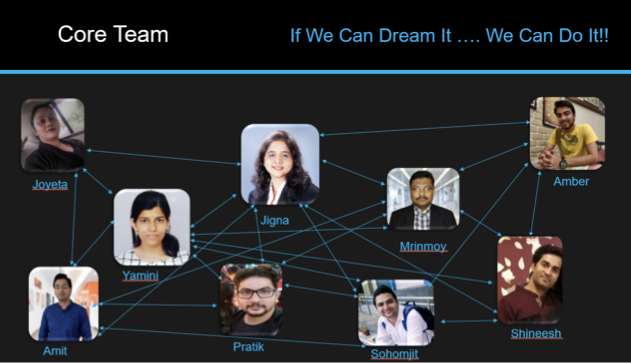

| Name | Email |
| --- | --- |
| Amit | amit.kr.dhanuka@gmail.com |
| Amber | amberjain.iet@gmail.com |
| Jigna | jignazt@yahoo.com |
| Joyeta | joyeta.instru@gmail.com |
| Mrinmoy | mrinmoydey.dey@gmail.com |
| Pratik | pratikbarjatya@gmail.com |
| Shineesh | Shineesh@gmail.com |
| Sohomjit | sunny.sohomjit13@gmail.com |
| Yamini | yaminijoshi1989@gmail.com |


## THANK YOU !